# Import libraries

In [1]:
!pip install numpy
!pip install pandas
!pip install kagglehub
!pip install gtts
!pip install playsound
!pip install wordcloud
!pip install tensorflow
!pip install pillow
!pip install matplotlib


In [2]:
import numpy as np 
import pandas as pd 
import os
import kagglehub
import glob
from gtts import gTTS
from playsound import playsound
from IPython import display
import collections
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# IMPORTANTE ELIMINA LAS COMILLAS SI ESTÁS EN COLLAB

In [ ]:
''' 
from google.colab import drive
drive.mount('/content/drive')
save_dir = "/content/drive/My Drive/ProyectoTermo/"
'''

# # IMPORTANTE!! CAMBIA LA RUTA ENTRE COMILLAS (save_dirt )POR LA RUTA DONDE TIENES EL MODELO E IMAGENES DE PRUEBA

In [5]:
# save_dir = r"C:/Users/Josue/Desktop/ProyectoTermo/"

# Import encoder and decoder

In [6]:
encoder = load_model(save_dir + "encoder_model", compile=False)
decoder = load_model(save_dir + "decoder_model", compile=False)

with open(save_dir + "tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

with open(save_dir + "index_to_word.pkl", "rb") as f:
    index_to_word = pickle.load(f)

with open(save_dir + "word_to_index.pkl", "rb") as f:
    word_to_index = pickle.load(f)


inception = InceptionV3(include_top=False, weights="imagenet")
image_features_extract_model = tf.keras.Model(inputs=inception.input, outputs=inception.output)

print("SUCCESS")




SUCCESS


# Evaluation Functions

In [7]:
max_length = 40  
attention_feature_shape = 64
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_feature_shape))
    
    # Maybe i need to change this val (1,512)
    hidden = tf.zeros((1, 512))  

    temp_input, _ = load_images(image)  # Load and process img
    img_tensor_val = image_features_extract_model(temp_input)  
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        # This comes from attribute from last code
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)  
        attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word.get(predicted_id, ''))

        if tokenizer.index_word.get(predicted_id) == '<end>':
            break

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions

#Cleaning text
def filt_text(text):
    remove_tokens = ['<start>', '<end>']
    return ' '.join([word for word in text.split() if word not in remove_tokens])

#Loading IMG 
def load_images(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img, image_path

# Image and audio plot

In [8]:
#SHow img
def plot_attention_map(result, attention_plot, image):
    temp_image = np.array(load_img(image))

    fig = plt.figure(figsize=(15, 15))
    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(8, 8)
        ax = fig.add_subplot(int(np.ceil(len_result / 2)), 2, l + 1)  # Convertir a entero
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
    plt.tight_layout()
    plt.show()
    
#Final function, generate audio + capos 
def pred_caption_audio(image_path, autoplay=False, weights=(0.5, 0.25, 0, 0)):
    result, attention_plot, pred_test = evaluate(image_path)
    pred_caption = ' '.join(result).rsplit(' ', 1)[0]
    pred_caption = filt_text(pred_caption)

    print('Prediction Caption:', pred_caption)
    plot_attention_map(result, attention_plot, image_path)

    speech = gTTS(pred_caption, lang='en', slow=False)
    speech.save('voice.mp3')
    display.display(display.Audio('voice.mp3', autoplay=autoplay))
    return image_path

# IMPORTANTE!! CAMBIA LA RUTA ENTRE COMILLAS (IMAGE_PATH )POR LA RUTA DONDE TIENES EL MODELO E IMAGENES DE PRUEBA

In [9]:
image_path = r"C:/content/drive/My Drive/ProyectoTermo/Prueba3.jpg"

# Test model

Prediction Caption: man wearing sunglasses and white jacket and blue clothing stands by house


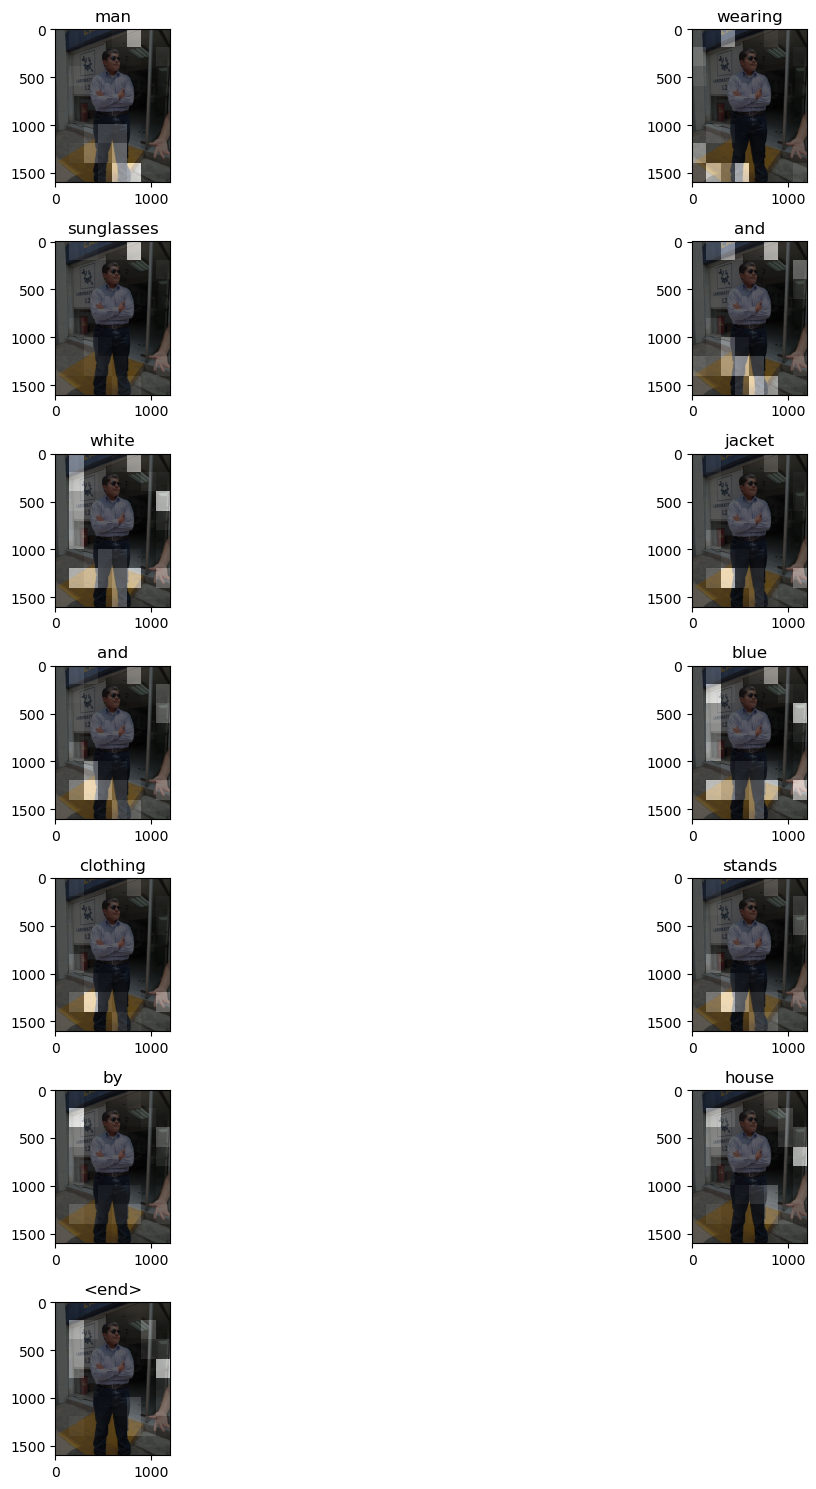

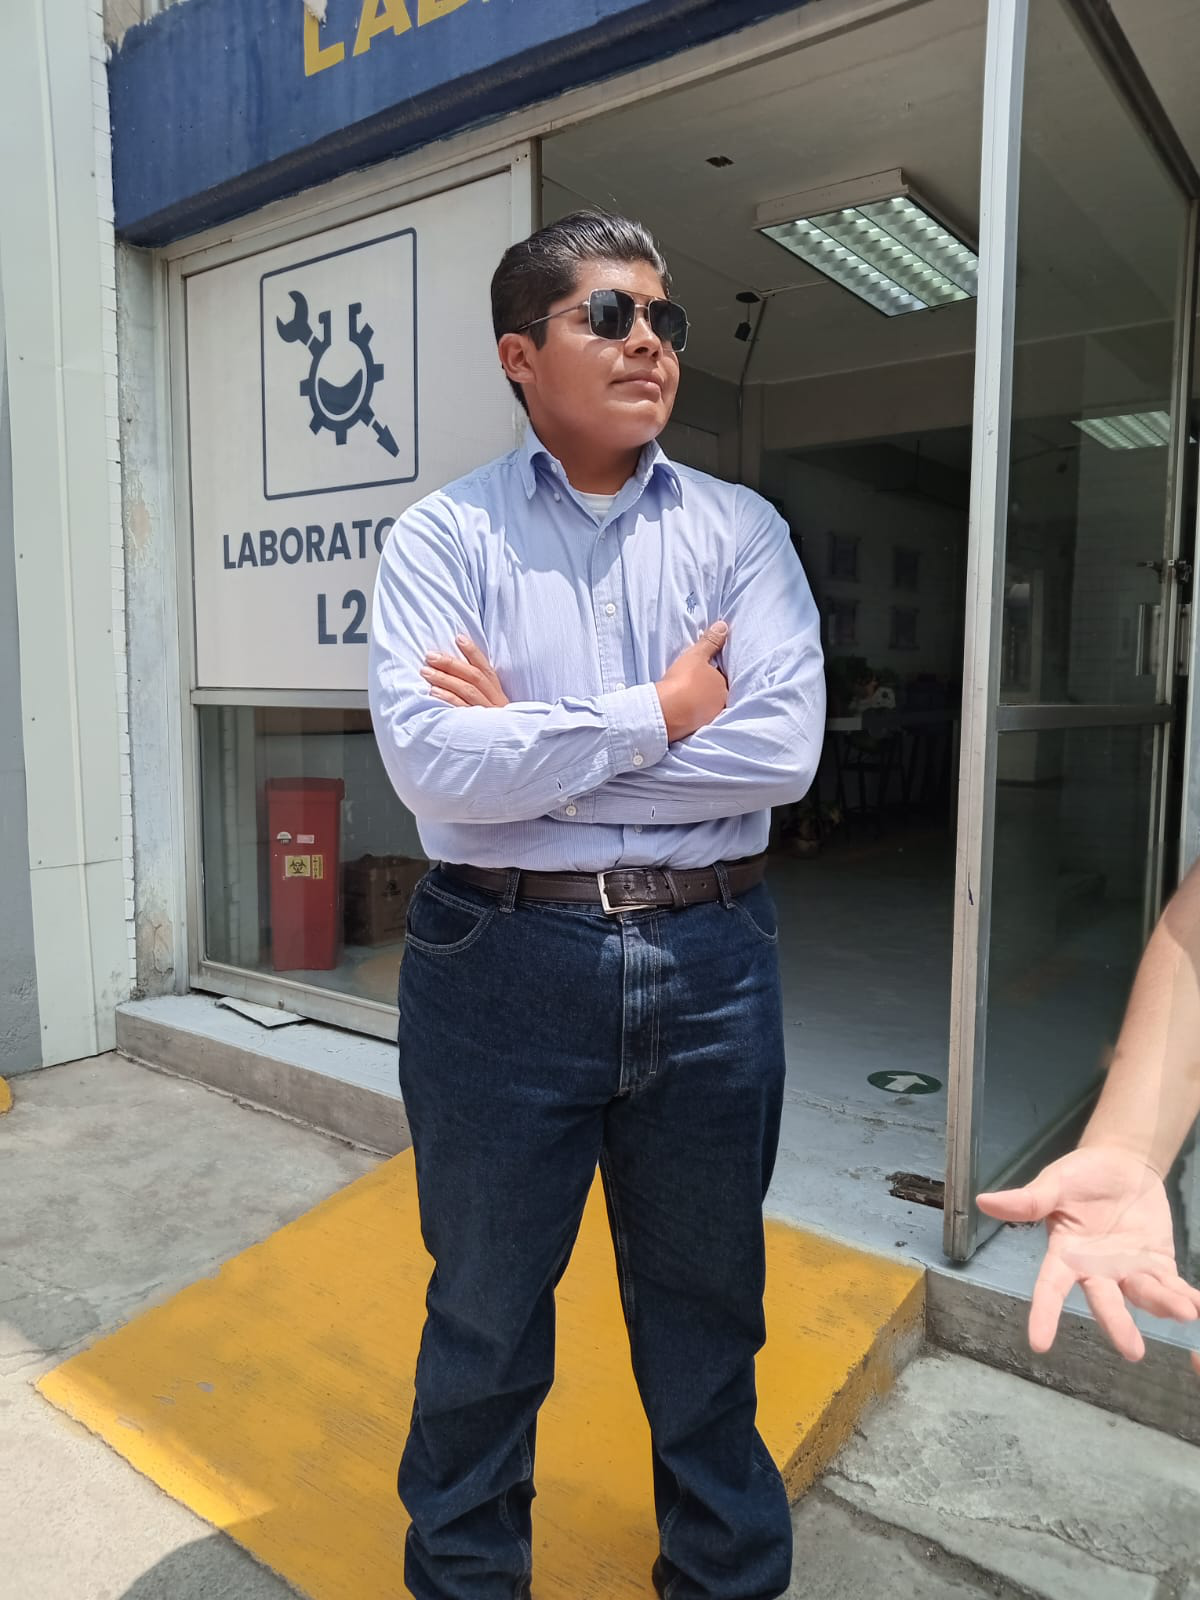

In [10]:

pred_caption_audio(image_path, autoplay=True)
Image.open(image_path)